## DYffusion `Forecastor`, $F_{\theta}$ Model Inference

* evaluate a trained DYffusion model using `.sample()`

In [6]:
import os
from pathlib import Path
from typing import Dict, Tuple, Optional, Any

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from omegaconf import OmegaConf
from scipy import io
from torch.utils.data import DataLoader
import xskillscore as xs
import xarray as xr

from rainnow.src.dyffusion.utilities.evaluation import evaluate_ensemble_crps
from rainnow.src.dyffusion.experiment_types.interpolation import InterpolationExperiment
from rainnow.src.dyffusion.experiment_types.forecasting_multi_horizon import (
    MultiHorizonForecastingDYffusion,
)
from rainnow.src.dyffusion.datamodules.imerg_precipitation import IMERGPrecipitationDataModule
from rainnow.src.interpolator_evaluation import (
    eval_trained_interpolators,
    eval_single_trained_interpolator,
    get_an_interpolated_ensemble_batch,
    plot_ens_eval_single_t_interpolation,
)
from rainnow.src.normalise import PreProcess
from rainnow.src.utilities.utils import (
    get_device,
    enable_inference_dropout,
)
from rainnow.src.utilities.loading import (
    load_model_checkpoint_for_eval,
    instantiate_interpolator_model_ckpt_from_config,
    load_model_state_dict,
    get_model_ckpt_path,
    load_imerg_datamodule_from_config,
)
from rainnow.src.plotting import (
    plot_a_sequence,
    plot_an_interpolated_sequence,
    plot_dyffusion_predictions,
)

from rainnow.src.utilities.instantiators import instantiate_multi_horizon_dyffusion_model

/Users/ds423/miniconda3/envs/irp_rain/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### `Helpers.`

In [7]:
# plotting helpers.
cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
rain_cmap = ListedColormap(cmap["Cmap_rain"])
global_params = {
    "font.size": 8,
    # "font.family": "Times New Roman",
    # "font.family": 'DejaVu Sans',
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
}
plt_params = {"wspace": 0.2, "hspace": 0.1}
ylabel_params = {"ha": "right", "va": "bottom", "labelpad": 1, "fontsize": 7.5}
plot_params = {"cmap": rain_cmap, "vmin": 0.1, "vmax": 8}

In [8]:
# get device.
device = get_device()

No GPU available! (device = cpu)


In [9]:
# DIR helpers.
CKPT_BASE_PATH = "/Users/ds423/git_uni/irp-ds423/rainnow/results/dyffusion_experiments"
CONFIGS_BASE_PATH = "/Users/ds423/git_uni/irp-ds423/rainnow/src/dyffusion/configs/"
CKPT_DIR = "checkpoints"
CKPT_CFG_NAME = "hparams.yaml"
DATAMODULE_CONFIG_NAME = "imerg_precipitation.yaml"
# whether or not to get last.ckpt or to get the "best model" ckpt (the other one in the folder).
GET_LAST = True

#### `instantiate the dataloaders + get batch of data`

In [10]:
datamodule = load_imerg_datamodule_from_config(
    cfg_base_path=CONFIGS_BASE_PATH,
    cfg_name=DATAMODULE_CONFIG_NAME,
    overrides={
        "boxes": ["1,0"],
        # change this depending on what models you're testing.
        "window": 1,
        "horizon": 8,
        "prediction_horizon": 8,
        "sequence_dt": 1,
    },
)
# datamodule.setup("fit")
datamodule.setup("validate")
datamodule.setup("test")
datamodule.setup("predict")

[2024-08-29 13:23:59][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-08-29 13:23:59][imerg_precipitation.py][INFO] --> validate data split: [202301010000, 202307010000]
[2024-08-29 13:26:14][torch_datasets.py][INFO] --> creating VAL tensor dataset.
[2024-08-29 13:26:14][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-29 13:26:14][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-08-29 13:26:14][imerg_precipitation.py][INFO] --> test data split: [202307010000, 202401010000]
[2024-08-29 13:28:27][torch_datasets.py][INFO] --> creating TEST tensor dataset.
[2024-08-29 13:28:27][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-29 13:28:27][abstract_datamodule.py][INFO] -->  Dataset test size: 851
[2024-08-29 13:28:27][i

In [11]:
# set up the dataloaders.
BATCH_SIZE = 12  # datamodule.hparams["batch_size"]

# train_dataloader = DataLoader(datamodule._data_train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(datamodule._data_val, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(datamodule._data_test, batch_size=BATCH_SIZE, shuffle=False)
predict_dataloader = DataLoader(datamodule._data_predict, batch_size=BATCH_SIZE, shuffle=False)

#### `Get a batch of data, X.`

In [12]:
# get a batch of data.
iter_loader = iter(predict_dataloader)
# iter_loader = iter(val_dataloader)
X = next(iter_loader)["dynamics"]

# debug info.
print(f"\n**  batch size = {BATCH_SIZE} **")
print(f"** num batches = {len(iter_loader)} **")
print(f"** num samples = {BATCH_SIZE * len(iter_loader)} ** ")
print(f"** sample dims: {X.shape}")  # (batch_size, sequence_length, channels, H, W)
print(f"** loaded sequence length = {datamodule.hparams.horizon + datamodule.hparams.window} **")


**  batch size = 12 **
** num batches = 1 **
** num samples = 12 ** 
** sample dims: torch.Size([11, 9, 1, 128, 128])
** loaded sequence length = 9 **


In [13]:
# X = next(iter_loader)["dynamics"]

#### `instantiate PreProcess() object`

In [14]:
# instantiate the pprocessor object.
pprocessor = PreProcess(
    percentiles=datamodule.normalization_hparams["percentiles"],
    minmax=datamodule.normalization_hparams["min_max"],
)

[2024-08-29 13:30:39][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]


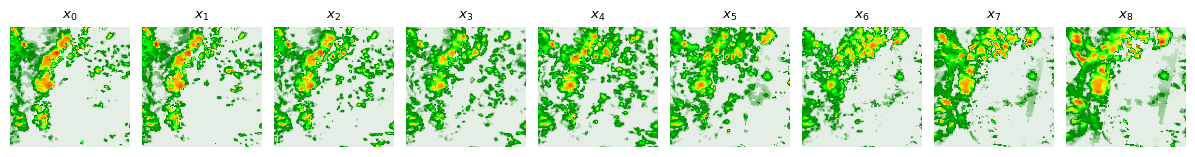

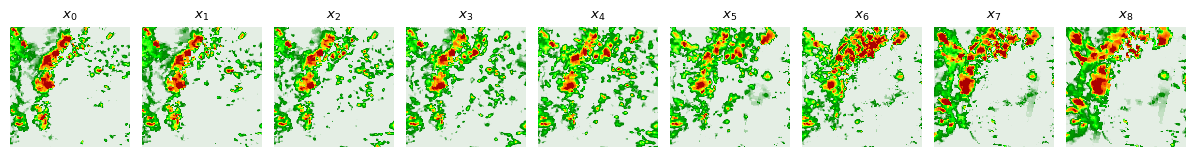

In [15]:
b = 6
# pre-preprocessed data.
plot_a_sequence(X, b=b, global_params=global_params, c=0, plot_params={"cmap": rain_cmap})
# Raw data.
plot_a_sequence(
    pprocessor.reverse_processing(X), b=b, global_params=global_params, plot_params=plot_params
)

----------

### `IRP Report` Plot
* the below is a plot for the `IRP paper`. 

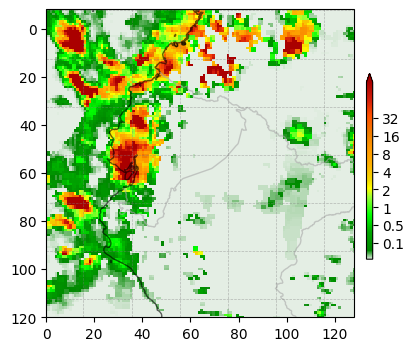

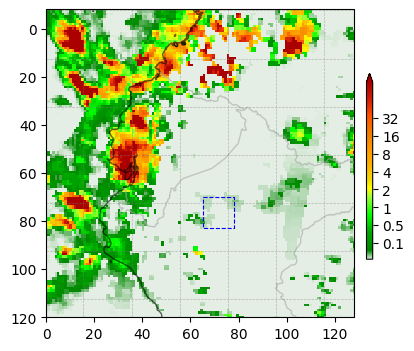

<Figure size 640x480 with 0 Axes>

In [16]:
# ** IRP REPORT PLOT **
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from rainnow.src.plotting import add_patch_to_geoplot

fig = plt.figure(figsize=(8, 4))
plt.rcParams.update(global_params)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-83.55, -70.75, -8.75, 4.05], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, edgecolor="black", linewidth=1, alpha=0.6)
ax.add_feature(cfeature.BORDERS, edgecolor="darkgrey", linewidth=1, alpha=0.6)
# ax.gridlines(draw_labels=True)

lons = np.linspace(-83.55, -70.75, 128)
lats = np.linspace(-8.75, 4.05, 128)

lon_grid, lat_grid = np.meshgrid(lons, lats)
im = ax.pcolormesh(
    lon_grid,
    lat_grid,
    #  pprocessor.reverse_processing(X[b, 8, 0, ...]),
    np.flipud(pprocessor.reverse_processing(X[b, 8, 0, ...])),
    transform=ccrs.PlateCarree(),
    cmap=rain_cmap,
    vmin=0.1,
    vmax=10,
)

# Set up ticks every 5 degrees
xticks = np.arange(-83.55, -70.55, 0.1)
yticks = np.arange(-8.75, 4.05, 0.1)
ax.set_xticks(xticks[::20], crs=ccrs.PlateCarree())
ax.set_xticklabels(labels=np.arange(0, len(xticks))[::20], fontsize=10)
ax.set_yticks(yticks[::20], crs=ccrs.PlateCarree())
ax.set_yticklabels(labels=np.arange(0, len(yticks))[::20][::-1], fontsize=10)

ax.gridlines(draw_labels=False, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
cbar = plt.colorbar(
    im, ax=ax, orientation="vertical", pad=0.02, **{"fraction": 0.01, "aspect": 30, "extend": "max"}
)
# cbar.ax.text(3.2, 1.1, r"$\text{mm}\cdot\text{h}^{-1}$",
#              transform=cbar.ax.transAxes,
#              ha='center', va='bottom', fontsize=9)
cbar.set_ticks(np.arange(1, 9, 1))
cbar.set_ticklabels(["0.1", "0.5", "1", "2", "4", "8", "16", "32"], fontsize=10)
ax.axis("on")

plt.show()
plt.tight_layout()

# add a small patch to reference the spatial resolution of IMERG compared to SEVIR.
add_patch_to_geoplot(
    ax,
    patch_size=13,
    lat_pixel_resolution=0.1,
    lon_pixel_resolution=0.1,
    top_left_lon_lat=(-83.55, 4.05),  # (longitude, latitude)
    nx=5,
    ny=6,
    box_params={"color": "blue", "linestyle": "--", "linewidth": 0.8},
)
fig

----------

#### `DYffusion Experiments:`

In [17]:
# fmt: off

# ckpt_id: <experiment description>
ckpt_dict = {
    # 4 experiments @ 5 epochs, num_preds = 1
    "dyffusion-wxhgom2m": "(data) w/ dp=0, .1, .3",
    "dyffusion-wolfkq9e": "(data) w/ dp=.1, .4, .4",
    "dyffusion-rxjnorzf": "(data+noise) 'uniform' [0,1] w/ dp=.1, .4, .4",
    "dyffusion-veyqmkhg": "(data+noise) 'DD' [0,1] w/ dp=.1, .4, .4",
    # experiment comments:
    # - dyffusion-wolfkq9e had best training and val curves. The noise added experiments have quite 'jumpy' val curves.
    # - all experiments struggle to decrease val.
    # - both 'data+noise' look very similar (as expected).
    # 15 epochs, num_preds = 1
    "dyffusion-vhtyoozz": "(data+noise) w/ DD noise + dp=.2, .4, .4",
    # 30 epochs, num_preds = 6
    # "dyffusion-l7rgzz6y": "(data) w/ dp=.1, .4, .4 30E",

    # 30 epochs (full trains)
    "dyffusion-whhm1cfo": "LPIPS + (data) w/ dp=.3, .0, .1, .3 + 30E",
    "dyffusion-dyuogsn7": "L1 + (data) w/ dp=.3, .0, .1, .3 + 30E",
    "dyffusion-ktm7stqx": "inter LPIPS and DYffusion L1 w/ dp=.3, .0, .1, .3 + 20E",
    "dyffusion-qwoe7ksf": "change loss.",
    "dyffusion-yx8ne4wh": "5 epochs LPIPS. no dropout in input.",
    "dyffusion-vnkctwj0": "15 epochs, [1,0] full sequence",
    "dyffusion-b7bakbzb": "5 epochs LPIPS. w/ dp: .2, .2, .5, .3 (+.2 on paper)",

    # NEW LOSS: 
    "dyffusion-7fntigzk": "[1,0] full sequence, 15 epochs.",
    "dyffusion-daftvdwg": "all boxes, full sequence, 20 epochs. LPIPS",
    "dyffusion-fyxpjp65": "all boxes, full sequence, 20 epochs. L1",
}

# fmt: on

#### `Load in a DYffusion model`

In [18]:
ckpt_id = "dyffusion-daftvdwg"
# ckpt_id = "dyffusion-fyxpjp65"

# instantiate a DYffusion model.
model = instantiate_multi_horizon_dyffusion_model(
    ckpt_id=ckpt_id,
    ckpt_base_path=CKPT_BASE_PATH,
    diffusion_config_overrides={
        # "interpolator_checkpoint_base_path":  "/teamspace/studios/this_studio/irp-ds423/rainnow/results/"
        "interpolator_checkpoint_base_path": "/Users/ds423/git_uni/irp-ds423/rainnow/results/interpolation_experiments"
    },
)

# get model checkpoint.
ckpt_path = get_model_ckpt_path(ckpt_id=ckpt_id, ckpt_base_path=CKPT_BASE_PATH, get_last=False)
state_dict = load_model_state_dict(ckpt_path=ckpt_path, device=device)
# load in weights and biases from the checkpoint model.
model._model.load_state_dict(state_dict)

# set model into eval mode.
model.eval()
model._model.eval()

# model.model.hparams.refine_intermediate_predictions = True

[2024-08-29 13:30:41][_base_experiment.py][INFO] --> Instantiated model: UNet, with # input/output/conditional channels: 1, 1, 1
[2024-08-29 13:30:41][_base_experiment.py][INFO] --> Instantiated model: UNet, with # input/output/conditional channels: 2, 1, 0
[2024-08-29 13:30:41][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-29 13:30:42][dyffusion.py][INFO] --> Successfully loaded (and frozen) interpolator (id: interpolation-cc2yoiyi).
[2024-08-29 13:30:42][_base_experiment.py][INFO] --> Instantiated diffusion model: DYffusion, with #diffusion steps=8


loading model checkpoint from /Users/ds423/git_uni/irp-ds423/rainnow/results/interpolation_experiments/interpolation-cc2yoiyi/checkpoints/ImergPrecipitation-interpolation-MH8-BS6-DYffusion_test_epoch028_seed11.ckpt.


[2024-08-29 13:30:42][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-29 13:30:42][forecasting_multi_horizon.py][INFO] --> ------------------- Setting num_predictions=1


UNet(
  (layer_activation): ReLU()
  (block_activation): ReLU()
  (output_activation): Tanh()
  (init_conv): Sequential(
    (0): Conv2d(2, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (dropout_input): Dropout(p=0.0, inplace=False)
  (dropout_input_for_residual): Dropout(p=0.0, inplace=False)
  (time_emb_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=64, out_features=128, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=128, out_features=128, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=64, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1

#### `Run inference with DYffusion model`

* Run inference on the visual ran event Cyclone Yaku. 
* Cyclone Yaku a cylone that hit Peru and Ecuador in early March 2023 ~ 7-15th March. The visual event was chosen to be the 9th March. It is a heavy rain event. 

In [19]:
plot_params = {"cmap": rain_cmap, "vmin": 0.5, "vmax": 10}
global_params = {"font.size": 8}

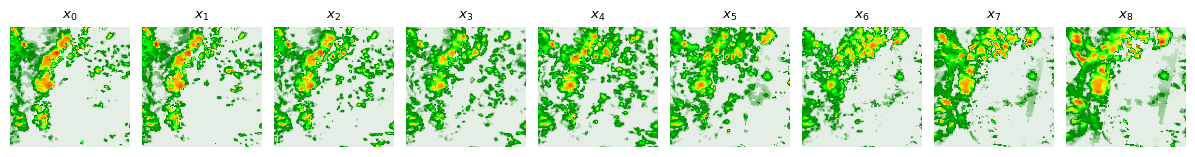

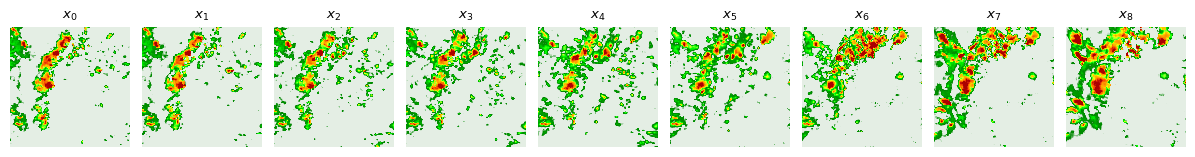

In [20]:
inputs = X.clone()
batch_num = 6
# get x0, interpolated values and xh from X.
x0 = inputs[batch_num, 0, :, :, :]
targets = pprocessor.reverse_processing(inputs)[batch_num, ...]

# pre-processed sequence.
plot_a_sequence(X, b=batch_num, global_params=global_params, plot_params={"cmap": rain_cmap})
# raw sequence (all preprocessing reversed).
plot_a_sequence(
    pprocessor.reverse_processing(inputs),
    b=batch_num,
    global_params=global_params,
    plot_params=plot_params,
)

#### `Make Predictions`

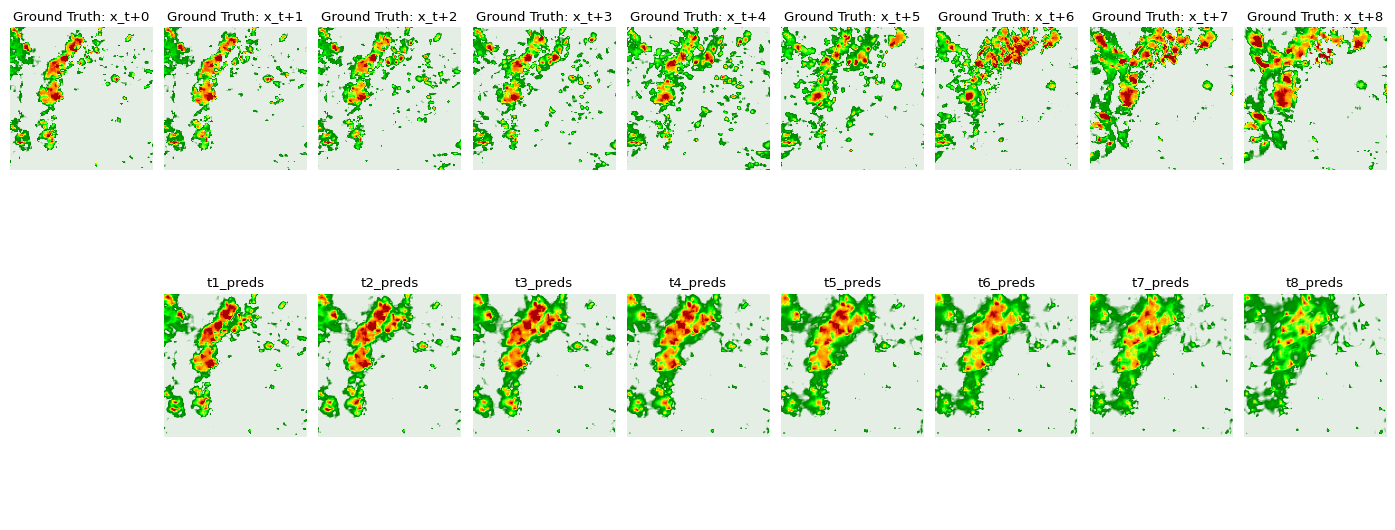

In [91]:
# make sampling predictions.
preds = model.model.sample(initial_condition=x0.unsqueeze(0))
predictions = {}
for k, pred in preds.items():
    if isinstance(model.model_final_layer_activation, nn.Tanh):
        # unnorm data.
        pred = (pred + 1) / 2

    predictions[k] = pprocessor.reverse_processing(pred)

# plot the predictions.
plot_dyffusion_predictions(
    targets=targets,
    predictions=predictions,
    plot_params=plot_params,
    global_params=global_params,
    figsize=(14, 6),
)

### END OF SCRIPT.